# Orientation and direction selectivity analysis

In [28]:
# general modules

import numpy as np
from datavyz import ge
from physion.analysis.read_NWB import Data
from physion.analysis.process_NWB import EpisodeResponse

#from physion.analysis.process_NWB import read as read_NWB

fn = '/home/yann/DATA/CaImaging/SSTcre_GCamp6s/2021_06_23/2021_06_23-13-25-43.nwb' 
protocol_id=1 # drifting gratings protocol

# load datafile
data = Data(fn)

# get levels of pupil and running-speed in the episodes (i.e. after realignement)
Pupil_episodes = EpisodeResponse(data, 
                                 protocol_id=protocol_id,
                                 quantity='Pupil')
Running_episodes = EpisodeResponse(data, 
                                   protocol_id=protocol_id,
                                   quantity='Running-Speed')

In [63]:
(360)%360

0

In [73]:
def shift_orientation_according_to_pref(angle, 
                                        pref_angle=0, 
                                        start_angle=-45, 
                                        angle_range=360):
    new_angle = (angle-pref_angle)%angle_range
    if new_angle>=angle_range+start_angle:
        return new_angle-angle_range
    else:
        return new_angle
# shift_orientation_according_to_pref(360, 45)

In [91]:
Nmax = 200000

interval_pre=[-2,0]
interval_post=[1,3]
stat_test_props=dict(interval_pre=interval_pre,
                     interval_post=interval_post,
                    test='wilcoxon', positive=True)

full_resp = {'roi':[], 'pupil_level':[], 'speed_level':[], 'angle_from_pref':[], 'post_level':[]}
for key in Pupil_episodes.varied_parameters.keys():
    full_resp[key] = []
    
for roi in np.arange(data.iscell.sum())[:Nmax]:
    ROI_EPISODES = EpisodeResponse(data,
                                   protocol_id=protocol_id,
                                   quantity='CaImaging', subquantity='dF/F',
                                   roiIndex = roi)
    # check if significant response in at least one direction and compute mean evoked resp
    resp = {'significant':[], 'pre':[], 'post':[]}
    for ia, angle in enumerate(ROI_EPISODES.varied_parameters['angle']):
        
        stats = ROI_EPISODES.stat_test_for_evoked_responses(episode_cond=ROI_EPISODES.find_episode_cond('angle', ia),
                                                            **stat_test_props)
        resp['significant'].append(stats.significant(threshold=0.01))
        resp['pre'].append(np.mean(stats.x))
        resp['post'].append(np.mean(stats.y))
    
    if np.sum(resp['significant'])>0:
        # if significant in at least one
        imax = np.argmax(np.array(resp['post'])-np.array(resp['pre']))
        amax = ROI_EPISODES.varied_parameters['angle'][imax]
        # we compute the post response relative to the preferred orientation for all episodes
        post_interval_cond = ROI_EPISODES.compute_interval_cond(interval_post)
        for iep, r in enumerate(ROI_EPISODES.resp):
            full_resp['angle_from_pref'].append(shift_orientation_according_to_pref(ROI_EPISODES.angle[iep], amax))
            full_resp['post_level'].append(ROI_EPISODES.resp[iep, post_interval_cond].mean())
            full_resp['roi'].append(roi)
            full_resp['speed_level'].append(Running_episodes.resp[iep, post_interval_cond].mean())
            full_resp['pupil_level'].append(Pupil_episodes.resp[iep, post_interval_cond].mean())
            
# transform to numpy array for convenience
for key in full_resp:
    full_resp[key] = np.array(full_resp[key])

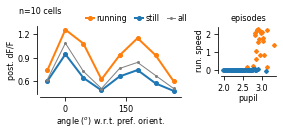

In [183]:
running_speed_threshold = 0.1
running_cond = (full_resp['speed_level']>=running_speed_threshold)


angles = np.unique(full_resp['angle_from_pref'])
curves = {'all_mean':[], 'all_std':[],
          'running_mean': [], 'running_std':[],
          'still_mean': [], 'still_std':[]}

for ia, angle in enumerate(angles):
    cond = full_resp['angle_from_pref']==angle
    curves['all_mean'].append(full_resp['post_level'][cond].mean())
    curves['all_std'].append(full_resp['post_level'][cond].std())
    # running
    curves['running_mean'].append(full_resp['post_level'][cond & running_cond].mean())
    curves['running_std'].append(full_resp['post_level'][cond & running_cond].std())
    # still
    curves['still_mean'].append(full_resp['post_level'][cond & ~running_cond].mean())
    curves['still_std'].append(full_resp['post_level'][cond & ~running_cond].std())
    
    
fig, ax = ge.figure(figsize=(1.5,1.5), right=6)
inset = ge.inset(fig, [.8,.5,.18,.3])
ge.plot(angles, curves['running_mean'], 
        color=ge.orange, ms=4, m='o', ax=ax, lw=2, label='running', no_set=True)
ge.plot(angles, curves['still_mean'], 
        color=ge.blue, ms=4, m='o', ax=ax, lw=2, label='still', no_set=True)
ge.plot(angles, curves['all_mean'], 
        color='grey', ms=2, m='o', ax=ax, no_set=True, label='all', lw=1)
ge.legend(ax, ncol=3, loc=(.3,1.))
ge.scatter(full_resp['pupil_level'][running_cond],full_resp['speed_level'][running_cond],
           title='episodes', ax=inset, no_set=True, color=ge.orange)
ge.scatter(full_resp['pupil_level'][~running_cond],full_resp['speed_level'][~running_cond],
           title='episodes', ax=inset, no_set=True, color=ge.blue)
ge.annotate(ax, 'n=%i cells\n' % len(np.unique(full_resp['roi'])), (0.,1.), ha='center')
ge.set_plot(ax, xlabel='angle ($^{o}$) w.r.t. pref. orient.', ylabel='post. dF/F')
ge.set_plot(inset, xlabel='pupil', ylabel='run. speed')

(<Figure size 119.055x102.047 with 1 Axes>, <AxesSubplot:>)

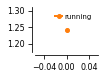

In [177]:
ge.plot(angles, curves['running_mean'].mean(axis=0), 
        #sy=np.array(curves['running_std']),
        color=ge.orange, ms=4, m='o', lw=2, label='running')

In [178]:
curves['running_mean']

array([[0.73551086, 1.31454697, 0.7036703 , 0.32190514, 1.85675345,
               nan,        nan, 0.34431378],
       [       nan, 3.01293967, 2.24204429, 1.5049321 , 1.27326619,
        5.13101205, 1.26893127,        nan],
       [2.0321807 , 1.66451234,        nan,        nan, 1.20937714,
        1.21535729, 1.97823226, 0.58081401],
       [0.45429707, 0.83981278, 0.77683487, 0.51966226, 0.52141664,
        0.84898842,        nan,        nan],
       [       nan, 1.52585572, 1.34739978, 1.12641156, 0.61120435,
        0.96341079, 1.05822152,        nan],
       [0.70871851, 1.06728821,        nan,        nan, 0.60775556,
        0.83247465, 0.98444365, 0.61353035],
       [1.83568751, 1.35815229,        nan,        nan, 1.01054864,
        1.56126714, 1.81598713, 1.3011184 ],
       [0.38642599, 0.61979417, 0.4669368 , 0.33357976,        nan,
               nan, 0.39828411, 0.37058541],
       [0.52590861, 0.62121667,        nan,        nan, 0.50352656,
        0.59871672, 0.682368

(<Figure size 119.055x102.047 with 1 Axes>, <AxesSubplot:>)

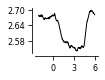

In [128]:
ge.plot(Pupil_episodes.t, Pupil_episodes.resp.mean(axis=0))#, sy=Pupil_episodes.resp.std(axis=0))

In [129]:
len(Pupil_episodes.resp)

80

0.5


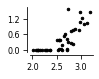

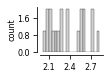

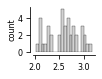

In [16]:
ge.scatter(Pupil_episodes.resp.mean(axis=1), Running_episodes.resp.mean(axis=1))
cond = (Running_episodes.resp.mean(axis=1)<0.25)
ge.hist(Pupil_episodes.resp.mean(axis=1)[cond])
ge.hist(Pupil_episodes.resp.mean(axis=1))
print(np.sum(cond)/len(cond))

## Datafile

We take a datafile that intermixes static and drifting gratings visual stimulation in a pseudo-randomized sequence

In [2]:
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'data.nwb')
FullData= Data(filename)
print('the datafile has %i validated ROIs (over %i from the full suite2p output) ' % (np.sum(FullData.iscell),
                                                                                      len(FullData.iscell)))

the datafile has 293 validated ROIs (over 461 from the full suite2p output) 


# Orientation selectivity

Number of episodes over the whole recording: 40/120 (with protocol condition)
----
A value in x_new is below the interpolation range.
Problem with episode 0 between (1.02, 6.02)s
----
A value in x_new is above the interpolation range.
Problem with episode 119 between (1193.52, 1198.52)s
[ok] episodes ready !


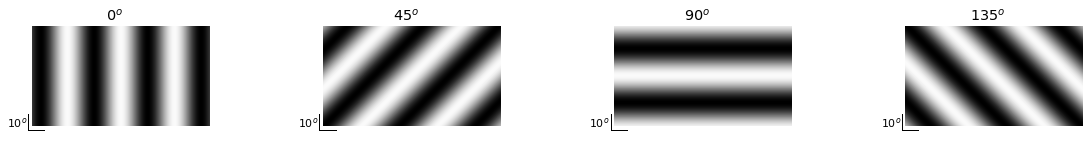

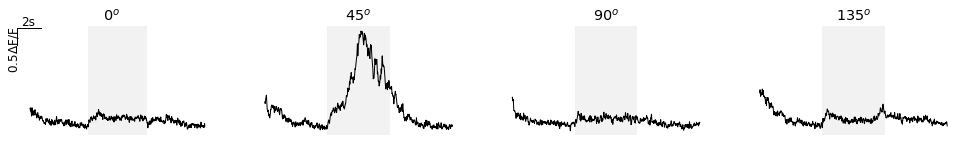

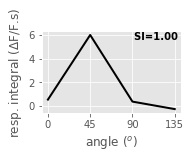

In [3]:
# Load data for FIRST PROTOCOL
data = CellResponse(FullData, protocol_id=0, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
# Show stimulation
fig, AX = data.show_stim('angle', figsize=(20,2))
# Compute and plot trial-average responses
fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
for i, angle in enumerate(data.varied_parameters['angle']):
    data.plot('angle',i, ax=AX[i], with_std=False)
    AX[i].set_title('%.0f$^o$' % angle)
# put all on the same axis range
YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
for ax in AX:
    ax.set_ylim(YLIM)
    data.add_stim(ax)
    ax.axis('off')
# add scale bar
add_bar(AX[0], Xbar=2, Ybar=0.5)
# Orientation selectivity plot based on the integral of the trial-averaged response
orientation_selectivity_plot(*data.compute_integral_responses('angle'))
# close the nwbfile
#data.io.close()

# Direction selectivity

Number of episodes over the whole recording: 80/120 (with protocol condition)
[ok] episodes ready !


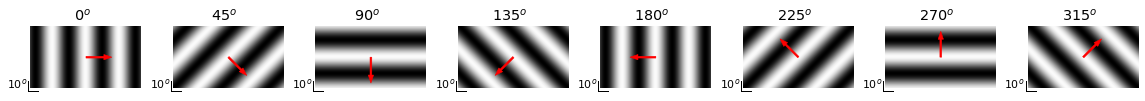

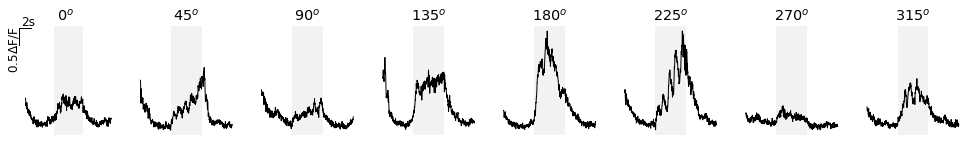

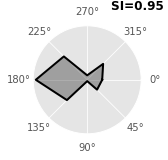

In [4]:
# Load data for FIRST PROTOCOL
data = CellResponse(FullData, protocol_id=1, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
# Show stimulation
fig, AX = data.show_stim('angle', figsize=(20,2), with_arrow=True)
# Compute and plot trial-average responses
fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
for i, angle in enumerate(data.varied_parameters['angle']):
    data.plot('angle',i, ax=AX[i], with_std=False)
    AX[i].set_title('%.0f$^o$' % angle)
# put all on the same axis range
YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
for ax in AX:
    ax.set_ylim(YLIM)
    data.add_stim(ax)
    ax.axis('off')
# add scale bar
add_bar(AX[0], Xbar=2, Ybar=0.5)
# Orientation selectivity plot based on the integral of the trial-averaged response
direction_selectivity_plot(*data.compute_integral_responses('angle'))
# close the nwbfile
#data.io.close()

Number of episodes over the whole recording: 80/120 (with protocol condition)
[ok] episodes ready !


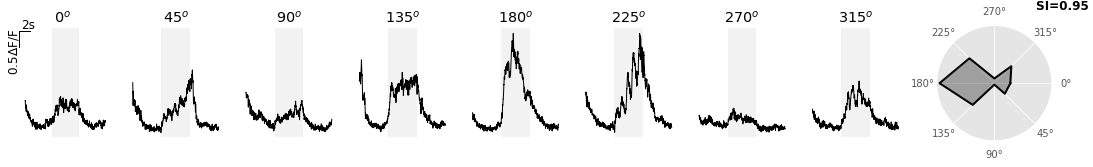

In [5]:
def direction_selectivity_analysis(FullData, roiIndex=0):
    data = CellResponse(FullData, protocol_id=1, quantity='CaImaging', subquantity='dF/F', roiIndex = roiIndex)
    fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
    plt.subplots_adjust(right=.85)
    for i, angle in enumerate(data.varied_parameters['angle']):
        data.plot('angle',i, ax=AX[i], with_std=False)
        AX[i].set_title('%.0f$^o$' % angle)
    # put all on the same axis range
    YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
    for ax in AX:
        ax.set_ylim(YLIM)
        data.add_stim(ax)
        ax.axis('off')
    # add scale bar
    add_bar(AX[0], Xbar=2, Ybar=0.5)
    # Orientation selectivity plot based on the integral of the trial-averaged response
    ax = plt.axes([0.85,0.1,0.15,0.8], projection='polar')
    direction_selectivity_plot(*data.compute_integral_responses('angle'), ax=ax)
    return fig
fig = direction_selectivity_analysis(FullData, roiIndex=8)

Number of episodes over the whole recording: 40/120 (with protocol condition)
Problem with episode 0 between (1.02, 6.02)s
Problem with episode 119 between (1193.52, 1198.52)s
[ok] episodes ready !


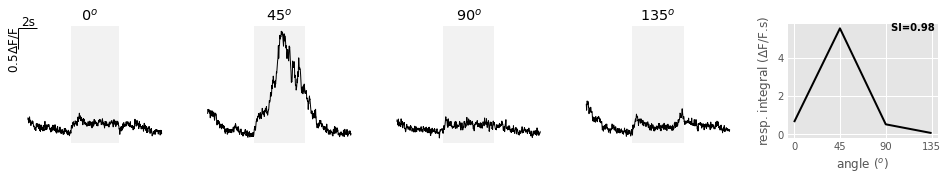

In [103]:
def orientation_selectivity_analysis(FullData, roiIndex=0):
    data = CellResponse(FullData, protocol_id=0, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
    fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(14,2.))
    plt.subplots_adjust(right=.8)
    for i, angle in enumerate(data.varied_parameters['angle']):
        data.plot('angle',i, ax=AX[i], with_std=False)
        AX[i].set_title('%.0f$^o$' % angle)
    YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
    for ax in AX:
        ax.set_ylim(YLIM)
        data.add_stim(ax)
        ax.axis('off')
    add_bar(AX[0], Xbar=2, Ybar=0.5)
    ax = plt.axes([0.85,0.1,0.15,0.8])
    orientation_selectivity_plot(*data.compute_integral_responses('angle'), ax=ax)
orientation_selectivity_analysis(FullData, roiIndex=8)

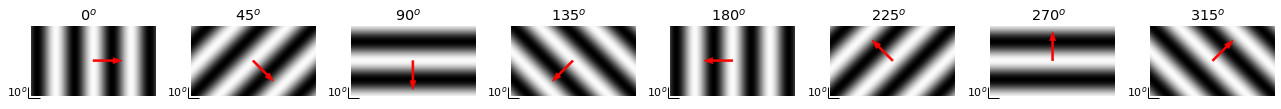

In [105]:
fig, AX = data.show_stim('angle', figsize=(20,2), with_arrow=True)
fig.savefig('/home/yann/Desktop/data2/stim.svg')